# CMP466 Project: Coral Reef Bleaching Classification
*       Dataset Name: A Global Coral-Bleaching Database, 1980-2020

*       I. Data Cleaning and Preprocessing
*       II. Machine Learning Methods
*               a. Decision Tree Classifier
*               b. K-Nearest Neighbors (KNN) Classifier
*               c. Naive-Bayes Classifier
*               d. Support Vector Machine (SVM) Classifer - Linear & Non-Linear

In [197]:
#ALL IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing 
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from collections import Counter

from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier

### I. Cleaning & Preprocessing the Dataset

In [198]:
dtype_options = {
    'Distance_to_Shore' : 'object',
    'Turbidity' : 'object',
    'Percent_Bleaching' : 'object'
}  # these features contain values that are either numerical or strings, so we need to change it to Object before proceeding

myfilepath = r'global_bleaching_environmental.csv'

In [199]:
df = pd.read_csv(myfilepath, dtype = dtype_options)

In [200]:
#display(df)
#df.describe()       # data summary (original dataset without cleaning)
#df.info()           # non-null count is equal to the number of records because the empty cells are labelled as 'nd', not as null or NaN (doesn't recognize it)
#df.nunique()           # returns an int value representing the number of unique values (applied to all columns)
#df.isnull()         # we're getting all 'False' because it doesn't recognize 'nd' as null

#### Identifying Columns/Records with 'nd' 

In [201]:
 # first, drop any record with no target

df_new1 = df[df['Percent_Bleaching'] != 'nd']
df_new1['Percent_Bleaching'].value_counts()

Percent_Bleaching
0        16607
5.5       1184
75         914
0.25       882
1          705
         ...  
5.32         1
5.28         1
5.27         1
5.23         1
97.22        1
Name: count, Length: 2271, dtype: int64

In [202]:
df_new1.shape            # now, the dataset is composed of 34515 records with the number of columns unchanged

(34515, 62)

In [203]:
# identify any columns with 'nd' occupying more than 10% of its rows

cols1 = df_new1.columns.values   # cols contains the columns names as a list
cols1_to_drop = []               # store columns to drop in this list
for c in cols1:                  # iterate through each value belonging to the columns and search for those columns with more than 10% of its rows as 'nd' 
    ndCount = (df_new1[c] == 'nd').sum()         
    if ndCount > 0.1 * df_new1.shape[0]:
        cols1_to_drop.append(c)
print(cols1_to_drop)            # Output: ['Reef_ID', 'Site_Name', 'Substrate_Name', 'Percent_Cover', 'Bleaching_Level', 'Site_Comments', 'Sample_Comments', 'Bleaching_Comments']
                                # To check the values of Bleaching_Level --> df_new['Bleaching_Level'].value_counts()

['Reef_ID', 'Site_Name', 'Substrate_Name', 'Percent_Cover', 'Bleaching_Level', 'Site_Comments', 'Sample_Comments', 'Bleaching_Comments']


In [204]:
cols1_to_drop.extend(['SSTA_Mean', 'Data_Source', 'Country_Name', 'State_Island_Province_Name', 'City_Town_Name', 'Date', 'Date_Day', 'Date_Month', 'Date_Year', 'Site_ID'])
len(cols1_to_drop)    # we added irrelevant or completely zero columns to remove as well

18

In [205]:
# now, drop the identified columns/features

df_new2 = df_new1.drop(columns = cols1_to_drop)   
#display(df_new2)

In [206]:
df_new2.shape                   # now, the dataset is composed of 34515 records and 54 columns (including target)  

(34515, 44)

In [207]:
df_new3 = df_new2.replace('nd', np.nan).dropna()       # remove any records with 'nd'
#df_new3

In [208]:
#df_new3.replace('nd', np.nan).isnull().sum()      # checking that all columns now have no null values

#### Checking Collinearity

TODO:
* Go over all features and see which ones have mixed data types (find a way to check data types for individual vals of the column)
* We can follow the paper, where any features with a collinearity coefficient higher than 0.8 are dropped
*       Some features mentioned in the paper are TSA_DHW and wind speed
* Features Highly Correlated with Coral Bleaching (As Indicated in Paper):
*       SST, SSTA, Coral Depth, Longitude, Latitude      


In [209]:
# identify all columns of data type 'object'
object_columns = df_new3.select_dtypes(include = ['object'])
#object_columns.info()

In [210]:
notFloat_cols = ['Ocean_Name', 'Realm_Name', 'Ecoregion_Name', 'Exposure']
float_cols = [col for col in object_columns if col not in notFloat_cols]
df_new4 = df_new3
df_new4[float_cols] = df_new3[float_cols].astype(float)
#df_new4.info()

In [211]:
df_new4[notFloat_cols] = df_new4[notFloat_cols].astype('string')
#df_new4.info()

In [212]:
#df_new4.corr(numeric_only = True)      # correlation matrix
#sns.heatmap(df_new4.corr(numeric_only = True), cmap = 'RdBu')

#### Next Step is to Encode Features
*     Exposure -> ordinal (integer encoding) 
*           df_new4['Exposure'].nunique() -> 3
*     Ocean Name -> nominal (one-hot encoding)
*     Other Names -> nominal (one-hot encoding)


In [213]:
df_new5 = df_new4

In [214]:
ordinal_encoder = OrdinalEncoder()
df_new5[['Exposure']] = ordinal_encoder.fit_transform(df_new5[['Exposure']])        # for reference: 0.0 is Exposed, 1.0 is Sheltered, 2.0 is Sometimes

In [215]:
encodedCols = ['Ocean_Name', 'Ecoregion_Name', 'Realm_Name']       # 5 cols for Ocean, 8 for Realm, 100 for Ecoregeion
df_new6 = pd.get_dummies(df_new5, columns=encodedCols).astype(int)
#display(df_new6)

##### So far (as of df_new6) we have 32675 records, and 154 columns
42 features total + 1 label column\
113 of the cols are OHE for 3 features\
during model training we will feed 152 features (removing the sample ID)

##### Discretizing Target Percent Bleaching

In [216]:
df_new6['Percent_Bleaching'].value_counts()

Percent_Bleaching
0     19111
1      2065
5      1563
2      1167
3       721
      ...  
94       10
79        9
97        7
84        6
99        2
Name: count, Length: 101, dtype: int64

#### Feature Selection Before Discretization

In [217]:
#df_new9 = df_new6

#y = df_new9['Percent_Bleaching'].to_numpy()
#X = df_new9.drop(columns=['Sample_ID', 'Percent_Bleaching']).to_numpy()


#X_new = SelectPercentile(f_classif, percentile = 50).fit_transform(X, y)

#X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.20, random_state=42)

#coral_DT = DecisionTreeClassifier()
#coral_DT.fit(X_train, y_train)

#print(coral_DT.score(X_train, y_train))
#print(coral_DT.score(X_test, y_test))

# Graph Discretized Bins vs Accuracy

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWa

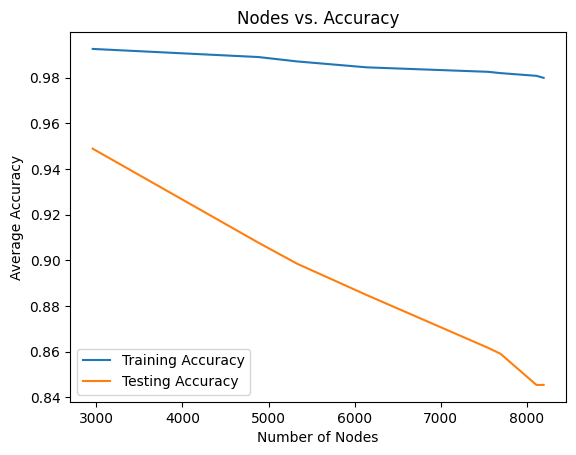

In [218]:
train_acc = []
test_acc = []
node_count = []

binsList = list(range(2,10))
for n in binsList:
    kbd = KBinsDiscretizer(n_bins=n, encode='ordinal', strategy='kmeans')
    df_new7 = df_new6 # make a copy

# The below is for when we want to mask the zeros
#    df_new7['Percent_Bleaching_Discretized'] = df_new7['Percent_Bleaching'] # create a new column (just so we can compare) we'll drop it later
#    mask = (df_new7['Percent_Bleaching_Discretized'] > 0) # Make a mask for the non-zero targets so we can discretize them
#    discretized_values = kbd.fit_transform(df_new7.loc[mask, ['Percent_Bleaching_Discretized']]) # discretize the non-zeros
#    df_new7.loc[mask, 'Percent_Bleaching_Discretized'] = discretized_values + 1 # to avoid overlapping zeros from original data and zero from dicsretization add 1

    df_new7['Percent_Bleaching_Discretized'] = df_new7['Percent_Bleaching']
    df_new7['Percent_Bleaching_Discretized'] = kbd.fit_transform(df_new7[['Percent_Bleaching_Discretized']])
    df_new7[['Percent_Bleaching','Percent_Bleaching_Discretized']]
   
    y = df_new7['Percent_Bleaching_Discretized'].to_numpy()
    X = df_new7.drop(columns=['Sample_ID', 'Percent_Bleaching','Percent_Bleaching_Discretized']).to_numpy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    coralDT = DecisionTreeClassifier() #create the tree
    coralDT.fit(X_train, y_train) #train the tree
    train_acc.append(coralDT.score(X_train, y_train)) #retrieve the training accuracy from transforming
    test_acc.append(coralDT.score(X_test, y_test))  #retrieve the testing accuracy from transforming
    node_count.append(coralDT.tree_.node_count) #retrieve the nodes used

plt.plot(node_count, train_acc, label='Training Accuracy')
plt.plot(node_count, test_acc, label='Testing Accuracy')
plt.xlabel('Number of Nodes')
plt.ylabel('Average Accuracy')
plt.title('Nodes vs. Accuracy')
plt.legend()
plt.show()


#    df_new7[['Percent_Bleaching','Percent_Bleaching_Discretized']]

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWa

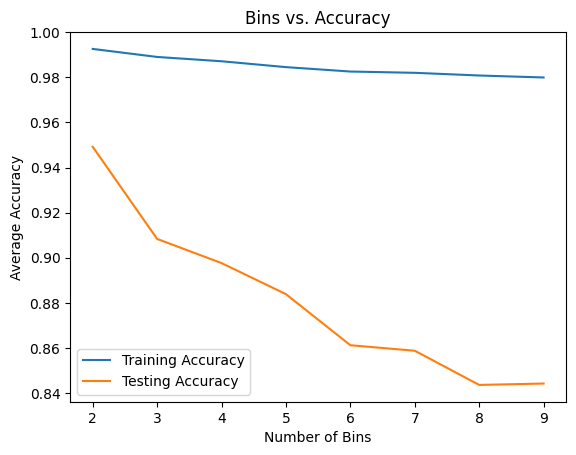

In [219]:
train_acc = []
test_acc = []

binsList = list(range(2,10))
for n in binsList:
    kbd = KBinsDiscretizer(n_bins=n, encode='ordinal', strategy='kmeans')
    df_new7 = df_new6 # make a copy

# The below is for when we want to mask the zeros
#    df_new7['Percent_Bleaching_Discretized'] = df_new7['Percent_Bleaching'] # create a new column (just so we can compare) we'll drop it later
#    mask = (df_new7['Percent_Bleaching_Discretized'] > 0) # Make a mask for the non-zero targets so we can discretize them
#    discretized_values = kbd.fit_transform(df_new7.loc[mask, ['Percent_Bleaching_Discretized']]) # discretize the non-zeros
#    df_new7.loc[mask, 'Percent_Bleaching_Discretized'] = discretized_values + 1 # to avoid overlapping zeros from original data and zero from dicsretization add 1

    df_new7['Percent_Bleaching_Discretized'] = df_new7['Percent_Bleaching']
    df_new7['Percent_Bleaching_Discretized'] = kbd.fit_transform(df_new7[['Percent_Bleaching_Discretized']])
    df_new7[['Percent_Bleaching','Percent_Bleaching_Discretized']]
   
    y = df_new7['Percent_Bleaching_Discretized'].to_numpy()
    X = df_new7.drop(columns=['Sample_ID', 'Percent_Bleaching','Percent_Bleaching_Discretized']).to_numpy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    coralDT = DecisionTreeClassifier() #create the tree
    coralDT.fit(X_train, y_train) #train the tree
    train_acc.append(coralDT.score(X_train, y_train)) #retrieve the training accuracy from transforming
    test_acc.append(coralDT.score(X_test, y_test))  #retrieve the testing accuracy from transforming

plt.plot(binsList, train_acc, label='Training Accuracy')
plt.plot(binsList, test_acc, label='Testing Accuracy')
plt.xlabel('Number of Bins')
plt.ylabel('Average Accuracy')
plt.title('Bins vs. Accuracy')
plt.legend()
plt.show()


# Discretization

In [220]:
#kbd = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='kmeans')   # K-means Discretization
                                                                        # Test to see which is the optimal number of bins
#df_new7 = df_new6 # make a copy
#df_new7['Percent_Bleaching_Discretized'] = df_new7['Percent_Bleaching'] # create a new column (just so we can compare) we'll drop it later
#mask = (df_new7['Percent_Bleaching_Discretized'] > 0) # Make a mask for the non-zero targets so we can discretize them
#discretized_values = kbd.fit_transform(df_new7.loc[mask, ['Percent_Bleaching_Discretized']]) # discretize the non-zeros
#df_new7.loc[mask, 'Percent_Bleaching_Discretized'] = discretized_values + 1 # to avoid overlapping zeros from original data and zero from dicsretization add 1
#df_new7[['Percent_Bleaching','Percent_Bleaching_Discretized']]

In [221]:
#df_new7['Percent_Bleaching_Discretized'].value_counts()

In [222]:
#kbd.bin_edges_

# Discretize without Mask

In [223]:
kbd = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='kmeans')   # K-means Discretization
                                                                        # Test to see which is the optimal number of bins
df_new7 = df_new6 # make a copy

df_new7['Percent_Bleaching_Discretized'] = df_new7['Percent_Bleaching'] # create a new column (just so we can compare) we'll drop it later

df_new7['Percent_Bleaching_Discretized'] = kbd.fit_transform(df_new7[['Percent_Bleaching_Discretized']]) # discretize the non-zeros
df_new7[['Percent_Bleaching','Percent_Bleaching_Discretized']]

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


,Percent_Bleaching,Percent_Bleaching_Discretized
0,50,1.0
1,50,1.0
2,50,1.0
3,50,1.0
4,50,1.0
...,...,...
35040,100,1.0
35041,100,1.0
35042,100,1.0
35043,100,1.0


In [224]:
df_new7['Percent_Bleaching_Discretized'].value_counts()

Percent_Bleaching_Discretized
0.0    29865
1.0     2810
Name: count, dtype: int64

In [225]:
kbd.bin_edges_

array([array([  0.       ,  31.5591283, 100.       ])], dtype=object)

# Undersampling

In [226]:
rus = RandomUnderSampler(random_state=0, sampling_strategy="majority")

df_new10 = df_new7

y = df_new10['Percent_Bleaching_Discretized'].to_numpy()
X = df_new10.drop(columns=['Sample_ID', 'Percent_Bleaching','Percent_Bleaching_Discretized']).to_numpy()

X_resampled, y_resampled = rus.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

[(0.0, 2810), (1.0, 2810)]


Undersampling Majority to be twice as large as minority

In [227]:
# rus = RandomUnderSampler(random_state=0, sampling_strategy=0.3)

# df_new10 = df_new7

# y = df_new10['Percent_Bleaching_Discretized'].to_numpy()
# X = df_new10.drop(columns=['Sample_ID', 'Percent_Bleaching','Percent_Bleaching_Discretized']).to_numpy()

# X_undersampled, y_undersampled = rus.fit_resample(X, y)
# print(sorted(Counter(y_resampled).items()))

Oversampling Minority to be same as majority

In [228]:
# smote_enn = SMOTEENN(random_state=0, sampling_strategy="all")
# X_resampled, y_resampled = smote_enn.fit_resample(X_undersampled, y_undersampled)
# print(sorted(Counter(y_resampled).items()))

In [229]:
X_resampled.shape

(5620, 152)

In [230]:
y_resampled.shape

(5620,)

# Combination of Under and Over Sampling

In [166]:
#smote_enn = SMOTEENN(random_state=0, sampling_strategy="all")
#df_new10 = df_new7
#y = df_new10['Percent_Bleaching_Discretized'].to_numpy()
#X = df_new10.drop(columns=['Sample_ID', 'Percent_Bleaching','Percent_Bleaching_Discretized']).to_numpy()
#X_resampled, y_resampled = smote_enn.fit_resample(X, y)
#print(sorted(Counter(y_resampled).items()))

In [167]:
#smote_tomek = SMOTETomek(random_state=0)
#df_new10 = df_new7
#y = df_new10['Percent_Bleaching_Discretized'].to_numpy()
#X = df_new10.drop(columns=['Sample_ID', 'Percent_Bleaching','Percent_Bleaching_Discretized']).to_numpy()
#X_resampled, y_resampled = smote_tomek.fit_resample(X, y)
#print(sorted(Counter(y_resampled).items()))

### Feature Selection

In [168]:
X_new_FS = SelectPercentile(f_classif, percentile = 50).fit_transform(X_resampled, y_resampled)

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 46  50  58  63  75  84  87 107 127 139 143] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [169]:
# df_new8 = df_new7
# y = df_new8['Percent_Bleaching_Discretized'].to_numpy()
# X = df_new8.drop(columns=['Sample_ID', 'Percent_Bleaching','Percent_Bleaching_Discretized']).to_numpy()
# X_new = SelectPercentile(f_classif, percentile = 50).fit_transform(X, y)

In [170]:
X_new_FS.shape

(5620, 76)

# Scaling

In [171]:
#scaler = preprocessing.MinMaxScaler ()
#X_new_rescaled = scaler.fit_transform (X_new) 
#print(X_new_rescaled)

In [172]:
# This one is slightly better than MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_new_rescaled = scaler.fit_transform (X_new_FS) 
print(X_new_rescaled)

[[ 1.21029671  0.37613537 -0.61724505 ... -1.10952425 -0.05343317
   3.31791305]
 [ 1.00081081 -0.76585311  0.32507541 ...  0.90128719 -0.05343317
  -0.30139428]
 [ 1.21029671  0.37613537 -0.61724505 ... -1.10952425 -0.05343317
   3.31791305]
 ...
 [-1.65267725  0.50636213 -2.03072574 ... -1.10952425 -0.05343317
   3.31791305]
 [ 0.93098217 -0.77587056  0.67844558 ...  0.90128719 -0.05343317
  -0.30139428]
 [ 0.93098217 -0.76585311  1.14960581 ...  0.90128719 -0.05343317
  -0.30139428]]


In [173]:
X_train, X_test, y_train, y_test = train_test_split(X_new_rescaled, y_resampled, test_size=0.20, random_state=42)

coral_DT = DecisionTreeClassifier()
coral_DT.fit(X_train, y_train)
print(coral_DT.score(X_train, y_train))
print(coral_DT.score(X_test, y_test))

0.989991103202847
0.854982206405694


## PCA (Principle Component Analysis)

In [174]:
# from sklearn.decomposition import PCA 

# for n in range(2, X_new_rescaled.shape[1]):
#     pca = PCA(n_components=n) 
#     pca.fit(X_new_rescaled) 
#     #print(pca.explained_variance_ratio_) 
#     #print(pca.singular_values_)

# plt.plot(node_count, train_acc, label='Training Accuracy')
# plt.plot(node_count, test_acc, label='Testing Accuracy')
# plt.xlabel('Number of Nodes')
# plt.ylabel('Average Accuracy')
# plt.title('Nodes vs. Accuracy')
# plt.legend()
# plt.show()
# #print(pca.explained_variance_ratio_.sum())

In [175]:
# pca = PCA()
# pca.fit(X_new_rescaled)

# # Check the explained variance ratio
# explained_variance_ratio = pca.explained_variance_ratio_
# print("Explained Variance Ratio:", explained_variance_ratio)

# # Determine the number of components to retain
# # For example, retain 95% of the variance
# cumulative_explained_variance = explained_variance_ratio.cumsum()
# num_components = (cumulative_explained_variance < 0.95).sum() + 1

# # Fit the PCA model with the chosen number of components
# pca = PCA(n_components=num_components)
# X_pca = pca.fit_transform(X_new_rescaled)

# # X_pca now contains the transformed features


# End of Preprocessing 

### c. Naive Bayes

In [231]:
from sklearn.naive_bayes import GaussianNB

In [193]:
X_train_NB, X_test_NB, y_train_NB, y_test_NB = train_test_split(X_new_rescaled, y_resampled, test_size=0.20, random_state=42)

### a. Naive Bayes with No Parameters

In [178]:
coral_NB_default = GaussianNB()
coral_NB_default.fit(X_train_NB, y_train_NB)
print(coral_NB_default.score(X_train_NB, y_train_NB))
print(coral_NB_default.score(X_test_NB, y_test_NB))

0.6156583629893239
0.5898576512455516


### b. Naive Bayes with var_smoothing Parameter Tuning (just testing out)

In [179]:
coral_NB_tuned = GaussianNB(var_smoothing = 1e-2)
coral_NB_tuned.fit(X_train_NB, y_train_NB)
print(coral_NB_tuned.score(X_train_NB, y_train_NB))
print(coral_NB_tuned.score(X_test_NB, y_test_NB))

0.7101868327402135
0.6850533807829181


### c. GridSearchCV

In [180]:
from sklearn.model_selection import GridSearchCV

param_grid_NB = {
    'var_smoothing': np.logspace(-50, 0, 50).tolist()
}

grid_search_NB = GridSearchCV(GaussianNB(), param_grid_NB, cv=5)
grid_search_NB.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': [1e-50, 1.0481131341546917e-49,
                                           1.0985411419875528e-48,
                                           1.1513953993264482e-47,
                                           1.2067926406393363e-46,
                                           1.2648552168552906e-45,
                                           1.3257113655901109e-44,
                                           1.3894954943731474e-43,
                                           1.4563484775012384e-42,
                                           1.5264179671752365e-41,
                                           1.5998587196060442e-40,
                                           1.676832936811003e-39,
                                           1.7575106248547965e-38...
                                           1.9306977288832458e-36,
                                           2.0235896477251637e-35,
                                           2.120950887920175e-34,
                                           2.222996482526191e-33,
                                           2.3299518105153814e-32,
                                           2.442053094548655e-31,
                                           2.5595479226995333e-30,
                                           2.682695795279738e-29,
                                           2.8117686979742367e-28,
                                           2.9470517025518097e-27,
                                           3.088843596477498e-26,
                                           3.2374575428176533e-25,
                                           3.3932217718953296e-24,
                                           3.5564803062231215e-23,
                                           3.7275937203149534e-22,
                                           3.906939937054621e-21, ...]})

In [181]:
grid_search_NB.best_estimator_

GaussianNB(var_smoothing=0.09540954763500041)

In [182]:
grid_search_NB.best_score_

0.7117421826721049

In [183]:
grid_search_NB.best_params_

{'var_smoothing': 0.09540954763500041}

### d. Plot

In [184]:
train_acc_NB = []
test_acc_NB = []
avg_train_acc_NB = []
avg_test_acc_NB = []
var_smoothingVals = np.logspace(-50, 0, 50).tolist()

for i in var_smoothingVals:
    for j in range(10):
        coral_NB_default = GaussianNB(var_smoothing = i)
        coral_NB_default.fit(X_train, y_train) 
        train_acc_NB.append(coral_NB_default.score(X_train_NB, y_train_NB)) 
        test_acc_NB.append(coral_NB_default.score(X_test_NB, y_test_NB))  
    
    avg_train_acc_NB.append(sum(train_acc_NB) / len(train_acc_NB))
    avg_test_acc_NB.append(sum(test_acc_NB) / len(train_acc_NB))

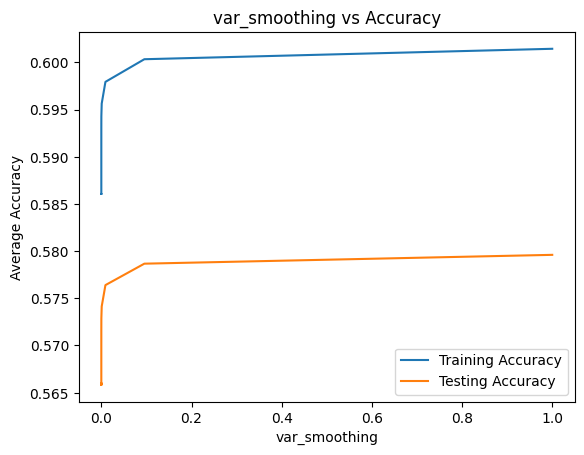

In [185]:
plt.plot(var_smoothingVals, avg_train_acc_NB, label='Training Accuracy')
plt.plot(var_smoothingVals, avg_test_acc_NB, label='Testing Accuracy')
plt.xlabel('var_smoothing')
plt.ylabel('Average Accuracy')
plt.title('var_smoothing vs Accuracy')
plt.legend()
plt.show()

### e. Evaluation Metrics for Naive Bayes with Optimal Parameter Tuning (Based on GridSearch)

In [232]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, roc_auc_score, confusion_matrix, precision_score, roc_curve

              precision    recall  f1-score   support

     Class 0       0.83      0.52      0.63       592
     Class 1       0.62      0.88      0.73       532

    accuracy                           0.69      1124
   macro avg       0.72      0.70      0.68      1124
weighted avg       0.73      0.69      0.68      1124


Accuracy Score:  0.6877224199288257
F1 Score:  0.7272727272727272
Recall Per Class:  0.8796992481203008
Precision:  0.6198675496688741
ROC_AUC Score:  0.6974509754115017
Confusion Matrix:
 [[305 287]
 [ 64 468]]


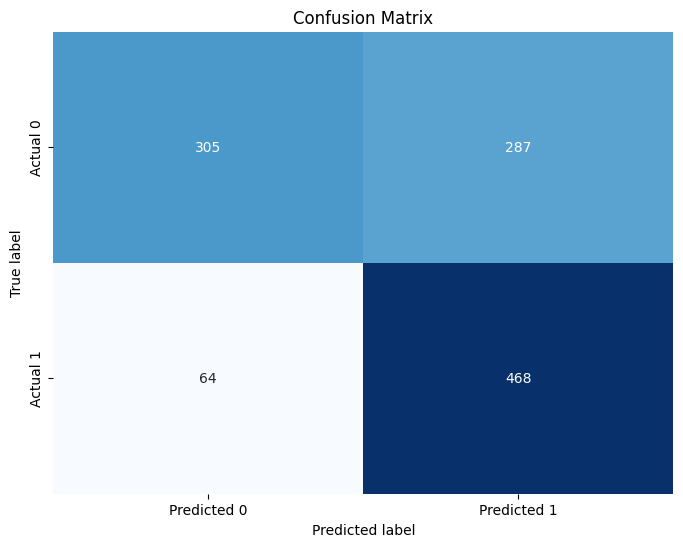

In [187]:
coral_NB = GaussianNB(var_smoothing = 0.09540954763500041)
coral_NB.fit(X_train_NB, y_train_NB)

coral_NB_predict = coral_NB.predict(X_test_NB)
print(classification_report(y_test_NB, coral_NB_predict, target_names = ['Class 0', 'Class 1'])) 
# precision, recall, f1-score, and support (the number of true instances for each label)

accuracy = accuracy_score(y_test_NB, coral_NB_predict)
# f1 = f1_score(y_test_NB, coral_NB_predict, average = 'weighted')        # f1 =  0.6785447731674416 ('weighted' accounts for class imbalance)
# recall = recall_score(y_test_NB, coral_NB_predict, average = 'weighted')    # recall 0.6877224199288257
# precision = precision_score(y_test_NB, coral_NB_predict, average = 'weighted')  # precision = 0.7287295637444601

f1 = f1_score(y_test_NB, coral_NB_predict)        # f1 =  0.7272727272727272
recall = recall_score(y_test_NB, coral_NB_predict)  # recall = 0.8796992481203008
precision = precision_score(y_test_NB, coral_NB_predict)  # precision = 0.6198675496688741

roc_auc = roc_auc_score(y_test_NB, coral_NB_predict)
confusion_matrix = confusion_matrix(y_test_NB, coral_NB_predict)

print("\nAccuracy Score: ", accuracy)
print("F1 Score: ", f1)
print("Recall Per Class: ", recall)
print("Precision: ", precision)
print("ROC_AUC Score: ", roc_auc)
print("Confusion Matrix:\n", confusion_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


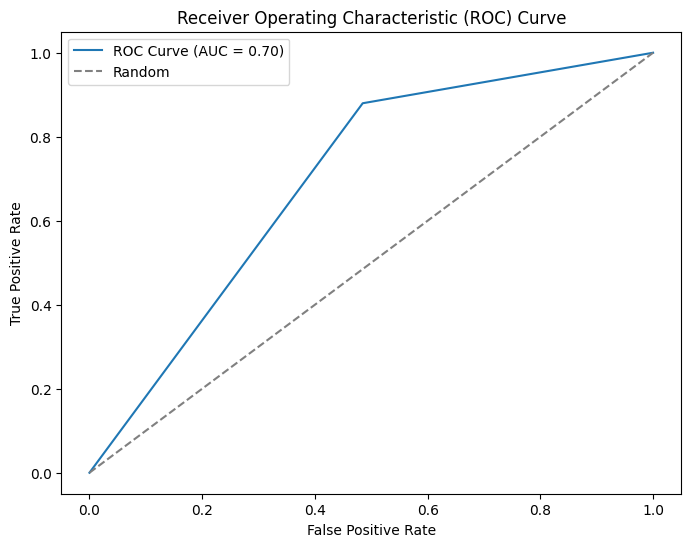

In [188]:
fpr_NB, tpr_NB, thresholds = roc_curve(y_test, coral_NB_predict)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_NB, tpr_NB, label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

### f. Naive Bayes Performance w/o Feature Selection

In [233]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_rescaled_nd = scaler.fit_transform (X_resampled) 
X_train_nd, X_test_nd, y_train_nd, y_test_nd = train_test_split(X_rescaled_nd, y_resampled, test_size=0.20, random_state=42)

              precision    recall  f1-score   support

     Class 0       0.86      0.38      0.53       592
     Class 1       0.58      0.93      0.71       532

    accuracy                           0.64      1124
   macro avg       0.72      0.66      0.62      1124
weighted avg       0.73      0.64      0.62      1124


Training Accuracy Score:  0.6694839857651246
Testing Accuracy Score:  0.6423487544483986
F1 Score:  0.7112068965517241
Recall Per Class:  0.9304511278195489
Precision:  0.5755813953488372
ROC_AUC Score:  0.6569485368827475
Confusion Matrix:
 [[227 365]
 [ 37 495]]
TPR: 


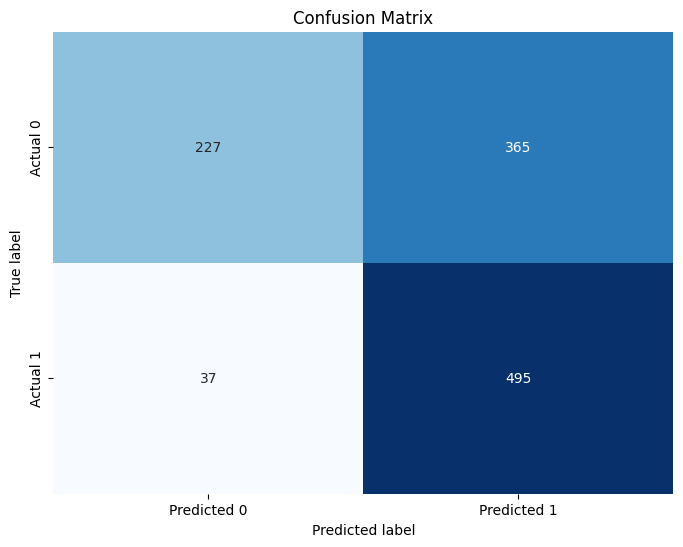

In [234]:
coral = GaussianNB(var_smoothing = 0.09540954763500041)
coral.fit(X_train_nd, y_train_nd)

coral_predict = coral.predict(X_test_nd)
print(classification_report(y_test_nd, coral_predict, target_names = ['Class 0', 'Class 1'])) 

accuracy = accuracy_score(y_test_nd, coral_predict)

f1 = f1_score(y_test_nd, coral_predict)       
recall = recall_score(y_test_nd, coral_predict) 
precision = precision_score(y_test_nd, coral_predict) 

roc_auc = roc_auc_score(y_test_nd, coral_predict)
confusion_matrix = confusion_matrix(y_test_nd, coral_predict)

print("\nTraining Accuracy Score: ", coral.score(X_train_nd, y_train_nd))
print("Testing Accuracy Score: ", accuracy)
print("F1 Score: ", f1)
print("Recall Per Class: ", recall)
print("Precision: ", precision)
print("ROC_AUC Score: ", roc_auc)
print("Confusion Matrix:\n", confusion_matrix)

print("TPR: ")

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()
